# Entrenamiento del modelo 

# Grupo 2

# usamos el dataset resultante del proceso de FE

In [12]:
%cd /app

/app


/usr/local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning:

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.



In [13]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.utils import shuffle
from joblib import dump
import matplotlib.pyplot as plt
from utils import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder



In [14]:
# Paths
BASE_DIR = './'
PATH_TO_TRAIN_FE_TEXT_LLM = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe_text_llm.csv")
PATH_TO_MODELS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/models")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_artifacts")

SEED = 42
TEST_SIZE = 0.2



In [15]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN_FE_TEXT_LLM)

# Convertir columnas de objetos a categóricas o numéricas
label_encoders = {}
categorical_columns = ['SentimentLanguage', 'coherence', 'friendly_with_children', 'friendly_with_other_pets', 'is_calm']

for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col].astype(str))
    label_encoders[col] = le

# Split del dataset
train, test = train_test_split(dataset, test_size=TEST_SIZE, random_state=SEED, stratify=dataset.AdoptionSpeed)

# Seleccionar características y etiqueta
features = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 
            'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 
            'VideoAmt', 'PhotoAmt', 'IsPureBreed', 'AgeInYears', 'Healthy', 'IsFree', 'Breed1_Rarity', 
            'StatePopulation', 'IsPeninsular', 'SentimentScore', 'SentimentMagnitude', 'SentimentLanguage'] + \
           [col for col in dataset.columns if col.startswith('contains_')] + \
           ['coherence', 'requires_running_space', 'friendly_with_children', 'friendly_with_other_pets', 
            'is_calm', 'is_energetic']

label = 'AdoptionSpeed'

X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]



In [16]:
# Entrenamiento inicial
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(y_train.unique())
}

lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)

lgb_model = lgb.train(lgb_params, lgb_train_dataset)

y_pred = lgb_model.predict(X_test).argmax(axis=1)

print("Cohen Kappa Score Inicial:", cohen_kappa_score(y_test, y_pred, weights='quadratic'))
display(plot_confusion_matrix(y_test, y_pred))



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 796
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 55
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359
Cohen Kappa Score Inicial: 0.3145015255100011


In [17]:
# Optimización de Hiperparámetros con Optuna
def lgb_objective(trial):
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),  # Ampliado
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),  # Ampliado
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 1.0),  # Ampliado
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # Ampliado
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Ampliado
    }
    
    lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
    lgb_model = lgb.train(lgb_params, lgb_train_dataset)
    
    return cohen_kappa_score(y_test, lgb_model.predict(X_test).argmax(axis=1), weights='quadratic')

# Función para Cross-Validation y Early Stopping
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return metric_name, value, is_higher_better

def cv_es_lgb_objective(trial):
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),  # Ampliado
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),  # Ampliado
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 1.0),  # Ampliado
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # Ampliado
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Ampliado
    }

    scores_ensemble = np.zeros((len(y_test), len(y_train.unique())))
    score_folds = 0
    n_splits = 5

    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index], label=y_train.iloc[if_index], free_raw_data=False)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index], label=y_train.iloc[oof_index], free_raw_data=False)

        lgb_model = lgb.train(
            lgb_params,
            lgb_if_dataset,
            valid_sets=lgb_oof_dataset,
            callbacks=[lgb.early_stopping(10, verbose=False)],
            feval=lgb_custom_metric_kappa
        )

        scores_ensemble += lgb_model.predict(X_test)
        score_folds += cohen_kappa_score(y_train.iloc[oof_index], lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1), weights='quadratic') / n_splits

    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p, :] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)
    upload_artifact(trial, predicted_filename, artifact_store)

    cm_filename = os.path.join(PATH_TO_TEMP_FILES, f'cm_{trial.study.study_name}_{trial.number}.jpg')
    plot_confusion_matrix(y_test, scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    upload_artifact(trial, cm_filename, artifact_store)

    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    return score_folds

# Crear estudio de Optuna
study_name = "05 - LGB Multiclass CV 03"  # Nuevo nombre de estudio
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name=study_name, load_if_exists=True)
study.optimize(cv_es_lgb_objective, n_trials=300)  # Aumentar el número de trials



/tmp/ipykernel_1486896/3271090702.py:80: ExperimentalWarning:

FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-07-01 00:54:23,855] A new study created in RDB with name: 05 - LGB Multiclass CV 03
/tmp/ipykernel_1486896/3271090702.py:67: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

/tmp/ipykernel_1486896/3271090702.py:71: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-07-01 00:54:32,199] Trial 0 finished with value: 0.34566652825017496 and parameters: {'lambda_l1': 0.0024338212996632943, 'lambda_l2': 0.002793448632215299, 'num_leaves': 183, 'feature_fraction': 0.41478865228810297, 'bagging_fraction': 0.3124641168972802, 'bagging_freq': 1, 'min_child_samples': 61}. Best is trial 0 with value: 0.34566652825017496.
/tmp/ipykernel_1486896/3271090702.py:67: ExperimentalWarni

In [18]:
# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo final con los mejores hiperparámetros
lgb_params.update(best_params)
lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
lgb_model = lgb.train(lgb_params, lgb_train_dataset)



Mejores hiperparámetros: {'lambda_l1': 7.654183591987084e-07, 'lambda_l2': 3.0021515619494636e-08, 'num_leaves': 158, 'feature_fraction': 0.43763336906780104, 'bagging_fraction': 0.979559058403628, 'bagging_freq': 9, 'min_child_samples': 35}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 54
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359


Kappa: 0.34710358332995594
Accuracy: 0.40880293431143716
Balanced Accuracy: 0.3457452235143224


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.11      0.19        82
           1       0.34      0.35      0.34       618
           2       0.35      0.39      0.37       807
           3       0.37      0.28      0.32       652
           4       0.52      0.60      0.56       840

    accuracy                           0.41      2999
   macro avg       0.44      0.35      0.36      2999
weighted avg       0.41      0.41      0.40      2999



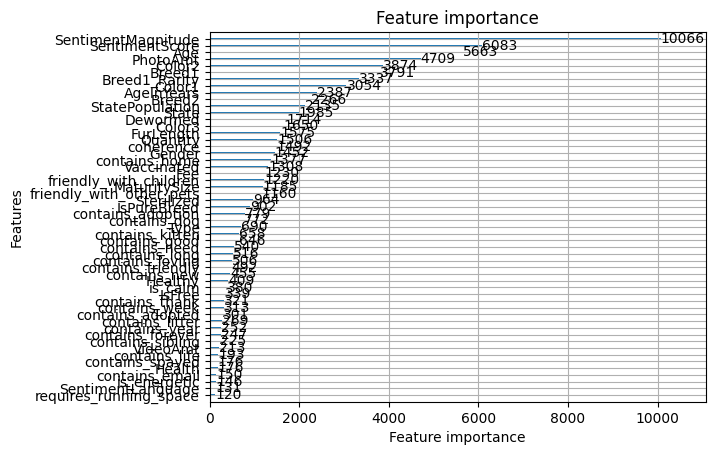

Total de datos en el dataset de entrenamiento: 11994
Datos utilizados en el entrenamiento actual: 11994
Porcentaje de datos utilizados: 100.00%


In [19]:
# Evaluar el modelo en el conjunto de prueba
y_pred = lgb_model.predict(X_test).argmax(axis=1)
kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f'Kappa: {kappa_score}')
print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_accuracy}')

# Mostrar la matriz de confusión
display(plot_confusion_matrix(y_test, y_pred))

# Información adicional del modelo
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
lgb.plot_importance(lgb_model)
plt.show()

# Tamaño total del dataset de entrenamiento
total_data = X_train.shape[0]
train_data = X_train.shape[0]
percentage_used = (train_data / total_data) * 100

print(f"Total de datos en el dataset de entrenamiento: {total_data}")
print(f"Datos utilizados en el entrenamiento actual: {train_data}")
print(f"Porcentaje de datos utilizados: {percentage_used:.2f}%")
